In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex

In [3]:
df= pd.read_csv(r'OpTransactionHistory27-11-2022.csv')
tp = pd.read_csv(r'name_cat.csv')

In [4]:
def extracting(row, n) -> str | None:
    try:
        return str(row["Particulars"]).split('/')[n]
    except:
        return None
        
def get_category(row):
    try:
        return tp[tp['Name']==row['Name']]['Category'].values[0]
    except:
        return None



df["Month"] = df.apply(lambda row: pd.to_datetime(
    row['Transaction Date']).month, axis=1)
df['Withdrawals'] = df['Withdrawals'].str.replace(',', '')
df['Deposits'] = df['Deposits'].str.replace(',', '')
df['Balance Amount'] = df['Balance Amount'].str.replace(',', '')
df = df.astype({"Withdrawals":'float',"Deposits":'float',"Balance Amount":"float"})
df["UPIid"] = df.apply(lambda row: extracting(row,-1), axis=1)
df["Name"] = df.apply(lambda row: extracting(row,3), axis=1)
df["Category"] = df.apply(lambda row: get_category(row), axis=1)

In [5]:
outliers = df[(df['Withdrawals'] >=10000) | (df['Deposits'] >= 10000)]
df.drop(outliers.index , inplace=True)
outliers.to_csv('outliers_10000.csv')
outliers

,SlNo,Transaction Date,Value Date,Particulars,Unnamed: 4,Unnamed: 5,Cheque Number,Withdrawals,Deposits,Balance Amount,Month,UPIid,Name,Category
2,3.0,18-Jun-2022,18-Jun-2022,BY CASH BR:BIDADI/CCEPN8833J,NaN,NaN,NaN,NaN,100000.0,100010.25,6.0,CCEPN8833J,None,NaN
3,4.0,18-Jun-2022,18-Jun-2022,NEFT:KING HYDROPONICS/,NaN,NaN,NaN,NaN,26500.0,126510.25,6.0,,None,NaN
284,285.0,26-Sep-2022,26-Sep-2022,Dr. Tran for funding A/c ZZ37342506/,NaN,NaN,NaN,100000.0,NaN,6476.07,9.0,,None,NaN


In [6]:
big_transactions = df[(df['Withdrawals'] >=500) | (df['Deposits'] >= 500)]
big_transactions.sort_values(by=['Withdrawals','Deposits'], ascending=False)
print(big_transactions.count())
big_transactions.to_csv('big_transactions.csv')

SlNo                48
Transaction Date    48
Value Date          48
Particulars         48
Unnamed: 4           0
Unnamed: 5           0
Cheque Number        0
Withdrawals         27
Deposits            21
Balance Amount      48
Month               48
UPIid               48
Name                47
Category             0
dtype: int64


In [7]:
monthly = df.groupby('Month',as_index=False).agg({"Withdrawals": "sum", "Deposits": "sum", "Balance Amount": "mean"})
monthly["Extra Expenditure"]=monthly.apply(lambda row: row["Withdrawals"] - row["Deposits"],axis=1)
monthly = monthly.sort_values(by="Extra Expenditure")
monthly["Extra Expenditure"].sum()
monthly=monthly.sort_index()
monthly.to_csv('monthly.csv')

<AxesSubplot:title={'center':'Monthly Extra Expenditure'}, xlabel='Month', ylabel='Rupees'>

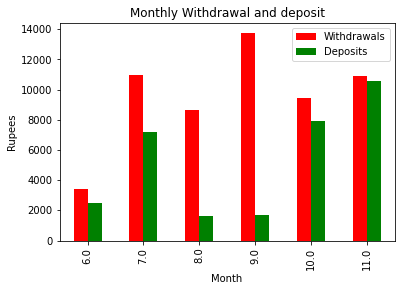

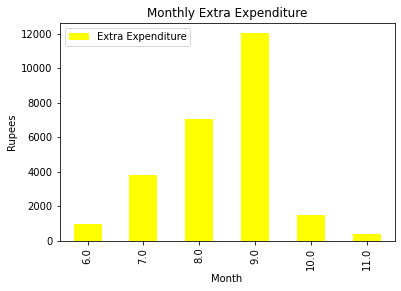

In [8]:
monthly.plot(x='Month',y=['Withdrawals','Deposits'],kind='bar', color=['red','green'],title='Monthly Withdrawal and deposit', ylabel = 'Rupees')
monthly.plot(x='Month',y='Extra Expenditure',kind='bar', color='yellow',title='Monthly Extra Expenditure', ylabel = 'Rupees')

In [9]:
namely = df.groupby('Name').agg(
    {"Withdrawals": "sum", "Deposits": "sum", "Balance Amount": "mean", "Particulars": "first", "UPIid":"first", "Transaction Date":"first", "SlNo":"count", "Category":"first"})
namely["Extra Expenditure"] = namely.apply(
    lambda row: row["Withdrawals"] - row["Deposits"], axis=1)
namely=namely.sort_values(by="Extra Expenditure",ascending = False)
print(namely["Extra Expenditure"].sum())
namely.to_csv('name_cat.csv')

26849.920000000002


In [10]:
categorically = df.groupby('Category').agg(
    {"Withdrawals": "sum", "Deposits": "sum", "SlNo":"count"})
categorically["Extra Expenditure"] = namely.apply(
    lambda row: row["Withdrawals"] - row["Deposits"], axis=1)
categorically=categorically.sort_values(by="Extra Expenditure",ascending = False)
print(categorically["Extra Expenditure"].sum())
categorically.to_csv('categorically.csv')

26849.920000000002


In [11]:
parents = df.groupby(['Month','Name'],as_index=False).agg({"Withdrawals": "sum", "Deposits": "sum", "Balance Amount": "mean"})
parents["Extra Expenditure"]=parents.apply(lambda row: row["Deposits"] - row["Withdrawals"],axis=1)
parents_dad = parents[parents['Name'].str.contains("JOHN B|APTIST NORONHA", na=False, case=False, regex=True)]
parents_mom = parents[parents['Name'].str.contains("SUNI", na=False, case=False, regex=True)]